In [1]:
# Install required packages.
import os

#!pip install torch==1.7.0
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/rusty1s/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rusty1s/pytorch_geometric.git to /tmp/pip-req-build-zlgmwbzm
  Running command git clone --filter=blob:none --quiet https://github.com/rusty1s/pytorch_geometric.git /tmp/pip-req-build-zlgmwbzm
  Resolved https://github.com/rusty1s/pytorch_geometric.git to commit cbfd1dbcc8460085fa6efb0cd9163883dda90611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from statistics import mean
from torch_geometric.datasets import TUDataset

import torch as th
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import metrics
from scipy.spatial.distance import hamming
import statistics
import pandas
import csv
from time import perf_counter


from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
#from torch_geometric.explain import Explainer, GNNExplainer
import torch_geometric.nn as gnn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
from torch_geometric.datasets import FakeDataset

num_graphs = 100
avg_num_nodes = 20
avg_degree = 15
node_feat_dim = 13
edge_feat_dim = 0
num_classes = 3
BATCH_SIZE = 10


fake_dataset = FakeDataset(num_graphs=num_graphs, avg_num_nodes=avg_num_nodes, avg_degree=avg_degree, num_channels=node_feat_dim,
                           edge_dim=edge_feat_dim, num_classes=num_classes,)

fake_dataloader = DataLoader(fake_dataset, batch_size=BATCH_SIZE, shuffle=True)

mutag_dataset = TUDataset(root='data/TUDataset', name='MUTAG')
mutag_dataloader = DataLoader(mutag_dataset, batch_size=BATCH_SIZE, shuffle=False)





In [65]:
print(len(mutag_dataset[0].x))

17


In [7]:
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"

In [8]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=dataset[0].x.size()[1],
                                       hidden_dim=dataset[0].x.size()[1], output_dim=3, num_hid_layers=2, Bias=classifier_bias,
                                       act_fun='ReLu', Weight_Initializer=1, dropout_rate=classifier_dropout)
print(GNN_Model)

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 13
GCN_plus_GAP Hidden_Dimension: 13
GCN_plus_GAP Output_Dimension: 3
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(13, 13)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=13, out_features=3, bias=True)
)


In [9]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [10]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [11]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [12]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        batch_loss = loss_calculations(soft, batch_of_graphs.y)

        Pred_Labels.extend(soft.argmax(dim=1).detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [13]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
          #torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 1.0809
Epoch: 002, Model Loss: 1.0680
Epoch: 003, Model Loss: 1.0658
Epoch: 004, Model Loss: 1.0670
Epoch: 005, Model Loss: 1.0613
Epoch: 006, Model Loss: 1.0589
Epoch: 007, Model Loss: 1.0517
Epoch: 008, Model Loss: 1.0535
Epoch: 009, Model Loss: 1.0482
Epoch: 010, Model Loss: 1.0498
Epoch: 011, Model Loss: 1.0400
Epoch: 012, Model Loss: 1.0383
Epoch: 013, Model Loss: 1.0254
Epoch: 014, Model Loss: 1.0220
Epoch: 015, Model Loss: 1.0205
Epoch: 016, Model Loss: 1.0191
Epoch: 017, Model Loss: 1.0008
Epoch: 018, Model Loss: 1.0040
Epoch: 019, Model Loss: 0.9919
Epoch: 020, Model Loss: 0.9902
Epoch: 021, Model Loss: 0.9645
Epoch: 022, Model Loss: 0.9605
Epoch: 023, Model Loss: 0.9470
Epoch: 024, Model Loss: 0.9401
Epoch: 025, Model Loss: 0.9229
Epoch: 026, Model Loss: 0.9088
Epoch: 027, Model Loss: 0.8959
Epoch: 028, Model Loss: 0.8865
Epoch: 029, Model Loss: 0.8779
Epoch: 030, Model Loss: 0.8677
Epoch: 031, Model Loss: 0.8560
Epoch: 032, Model Loss: 0.8514
Epoch: 0

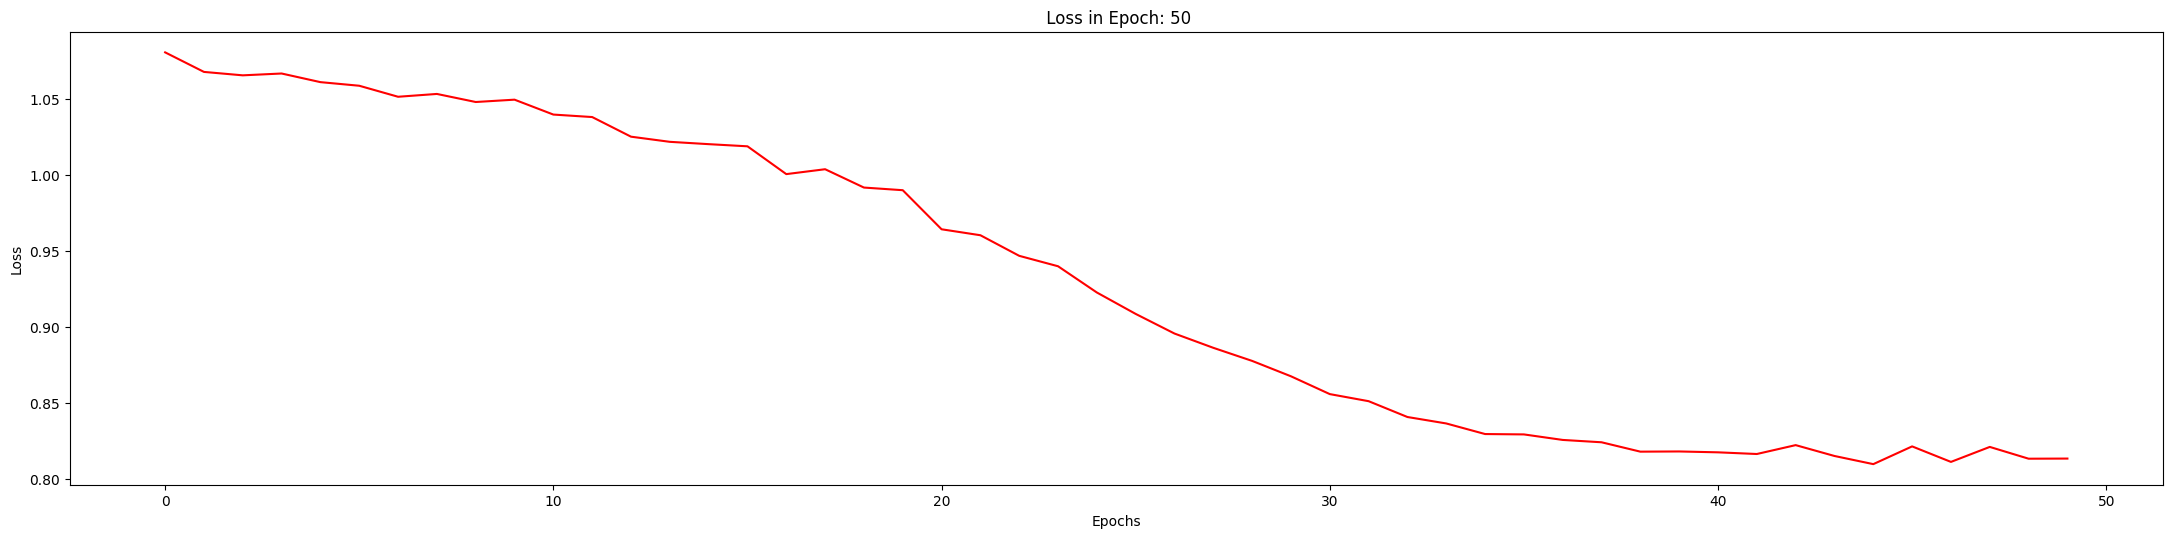

Epoch: 051, Model Loss: 0.8059
Epoch: 052, Model Loss: 0.8067
Epoch: 053, Model Loss: 0.8119
Epoch: 054, Model Loss: 0.8008
Epoch: 055, Model Loss: 0.8051
Epoch: 056, Model Loss: 0.8005
Epoch: 057, Model Loss: 0.8005
Epoch: 058, Model Loss: 0.8021
Epoch: 059, Model Loss: 0.7998
Epoch: 060, Model Loss: 0.8006
Epoch: 061, Model Loss: 0.8001
Epoch: 062, Model Loss: 0.7992
Epoch: 063, Model Loss: 0.8007
Epoch: 064, Model Loss: 0.7979
Epoch: 065, Model Loss: 0.7969
Epoch: 066, Model Loss: 0.7977
Epoch: 067, Model Loss: 0.7976
Epoch: 068, Model Loss: 0.7974
Epoch: 069, Model Loss: 0.7991
Epoch: 070, Model Loss: 0.7972
Epoch: 071, Model Loss: 0.8004
Epoch: 072, Model Loss: 0.7969
Epoch: 073, Model Loss: 0.8027
Epoch: 074, Model Loss: 0.8006
Epoch: 075, Model Loss: 0.8011
Epoch: 076, Model Loss: 0.8063
Epoch: 077, Model Loss: 0.7968
Epoch: 078, Model Loss: 0.8035
Epoch: 079, Model Loss: 0.7960
Epoch: 080, Model Loss: 0.8011
Epoch: 081, Model Loss: 0.7970
Epoch: 082, Model Loss: 0.7979
Epoch: 0

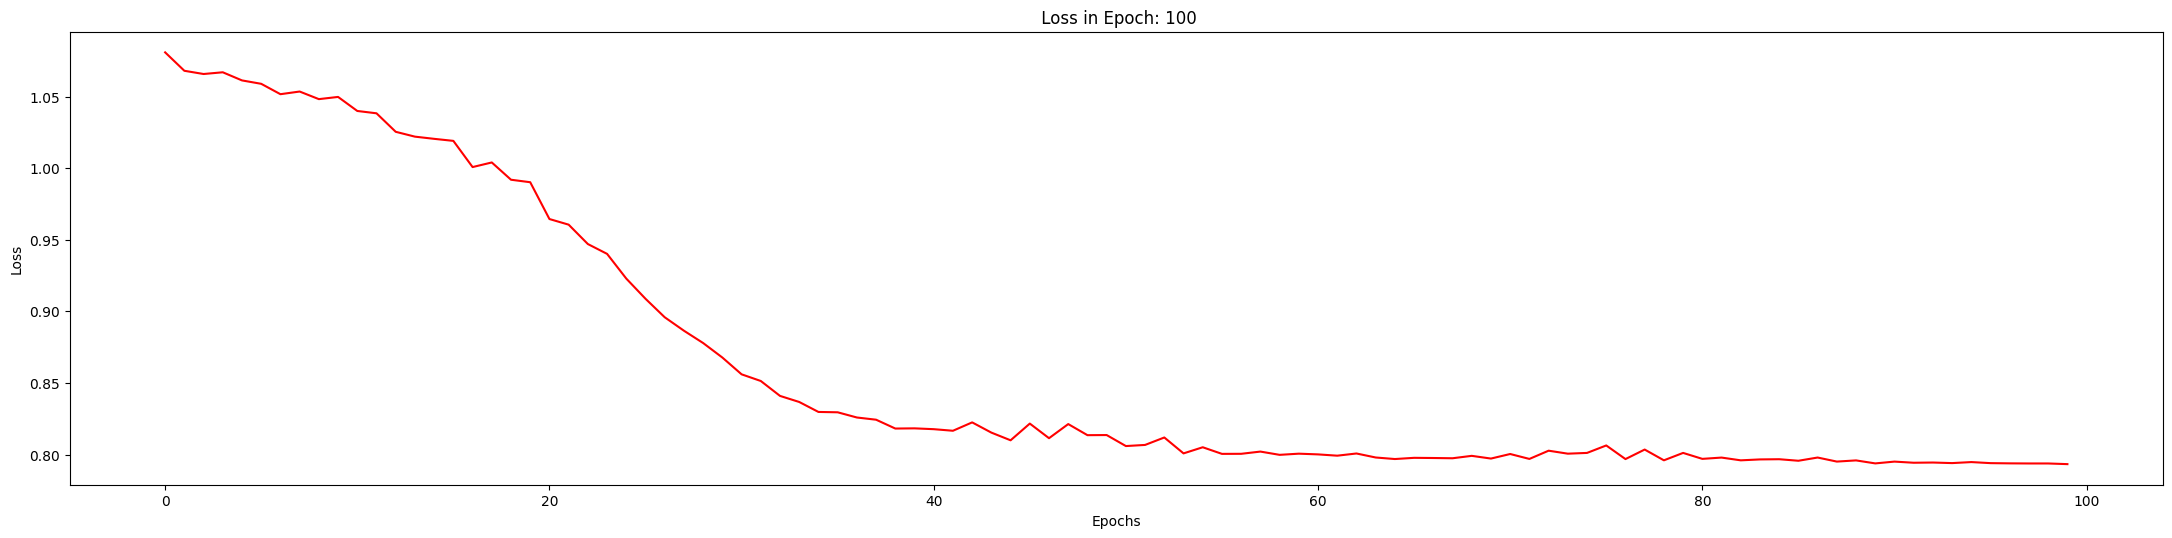

Epoch: 101, Model Loss: 0.7939
Epoch: 102, Model Loss: 0.7943
Epoch: 103, Model Loss: 0.7938
Epoch: 104, Model Loss: 0.7934
Epoch: 105, Model Loss: 0.7938
Epoch: 106, Model Loss: 0.7948
Epoch: 107, Model Loss: 0.7931
Epoch: 108, Model Loss: 0.7938
Epoch: 109, Model Loss: 0.7935
Epoch: 110, Model Loss: 0.7932
Epoch: 111, Model Loss: 0.7934
Epoch: 112, Model Loss: 0.7937
Epoch: 113, Model Loss: 0.7936
Epoch: 114, Model Loss: 0.7934
Epoch: 115, Model Loss: 0.7930
Epoch: 116, Model Loss: 0.7933
Epoch: 117, Model Loss: 0.7934
Epoch: 118, Model Loss: 0.7932
Epoch: 119, Model Loss: 0.7932
Epoch: 120, Model Loss: 0.7944
Epoch: 121, Model Loss: 0.7932
Epoch: 122, Model Loss: 0.7934
Epoch: 123, Model Loss: 0.7942
Epoch: 124, Model Loss: 0.7936
Epoch: 125, Model Loss: 0.7933
Epoch: 126, Model Loss: 0.7929
Epoch: 127, Model Loss: 0.7934
Epoch: 128, Model Loss: 0.7933
Epoch: 129, Model Loss: 0.7932
Epoch: 130, Model Loss: 0.7931
Epoch: 131, Model Loss: 0.7930
Epoch: 132, Model Loss: 0.7929
Epoch: 1

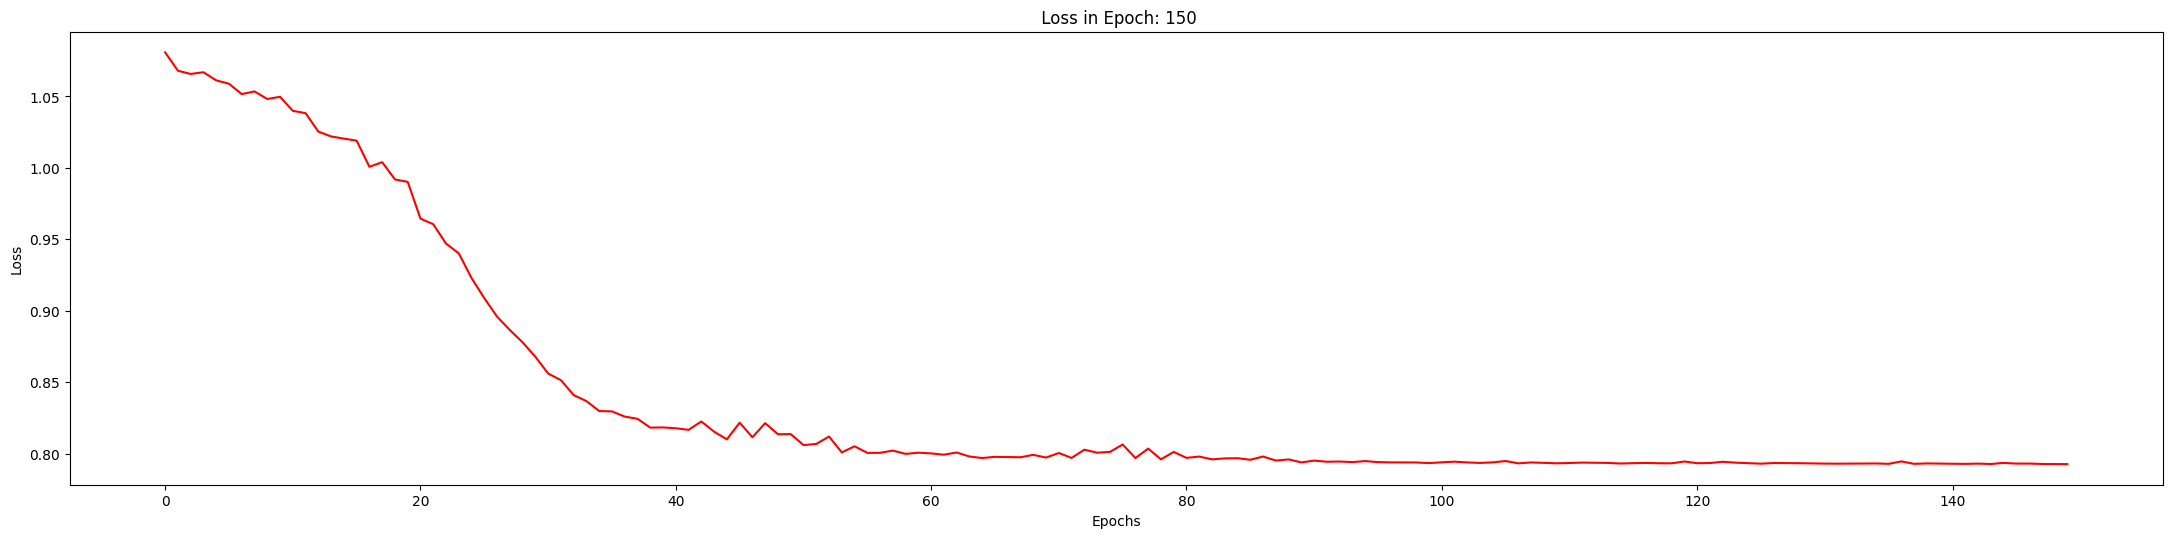

Epoch: 151, Model Loss: 0.7931
Epoch: 152, Model Loss: 0.7925
Epoch: 153, Model Loss: 0.7926
Epoch: 154, Model Loss: 0.7930
Epoch: 155, Model Loss: 0.7928
Epoch: 156, Model Loss: 0.7929
Epoch: 157, Model Loss: 0.7929
Epoch: 158, Model Loss: 0.7929
Epoch: 159, Model Loss: 0.7927
Epoch: 160, Model Loss: 0.7926
Epoch: 161, Model Loss: 0.7928
Epoch: 162, Model Loss: 0.7930
Epoch: 163, Model Loss: 0.7928
Epoch: 164, Model Loss: 0.7926
Epoch: 165, Model Loss: 0.7926
Epoch: 166, Model Loss: 0.7924
Epoch: 167, Model Loss: 0.7928
Epoch: 168, Model Loss: 0.7931
Epoch: 169, Model Loss: 0.7927
Epoch: 170, Model Loss: 0.7929
Epoch: 171, Model Loss: 0.7926
Epoch: 172, Model Loss: 0.7926
Epoch: 173, Model Loss: 0.7925
Epoch: 174, Model Loss: 0.7925
Epoch: 175, Model Loss: 0.7929
Epoch: 176, Model Loss: 0.7925
Epoch: 177, Model Loss: 0.7931
Epoch: 178, Model Loss: 0.7930
Epoch: 179, Model Loss: 0.7928
Epoch: 180, Model Loss: 0.7925
Epoch: 181, Model Loss: 0.7934
Epoch: 182, Model Loss: 0.7926
Epoch: 1

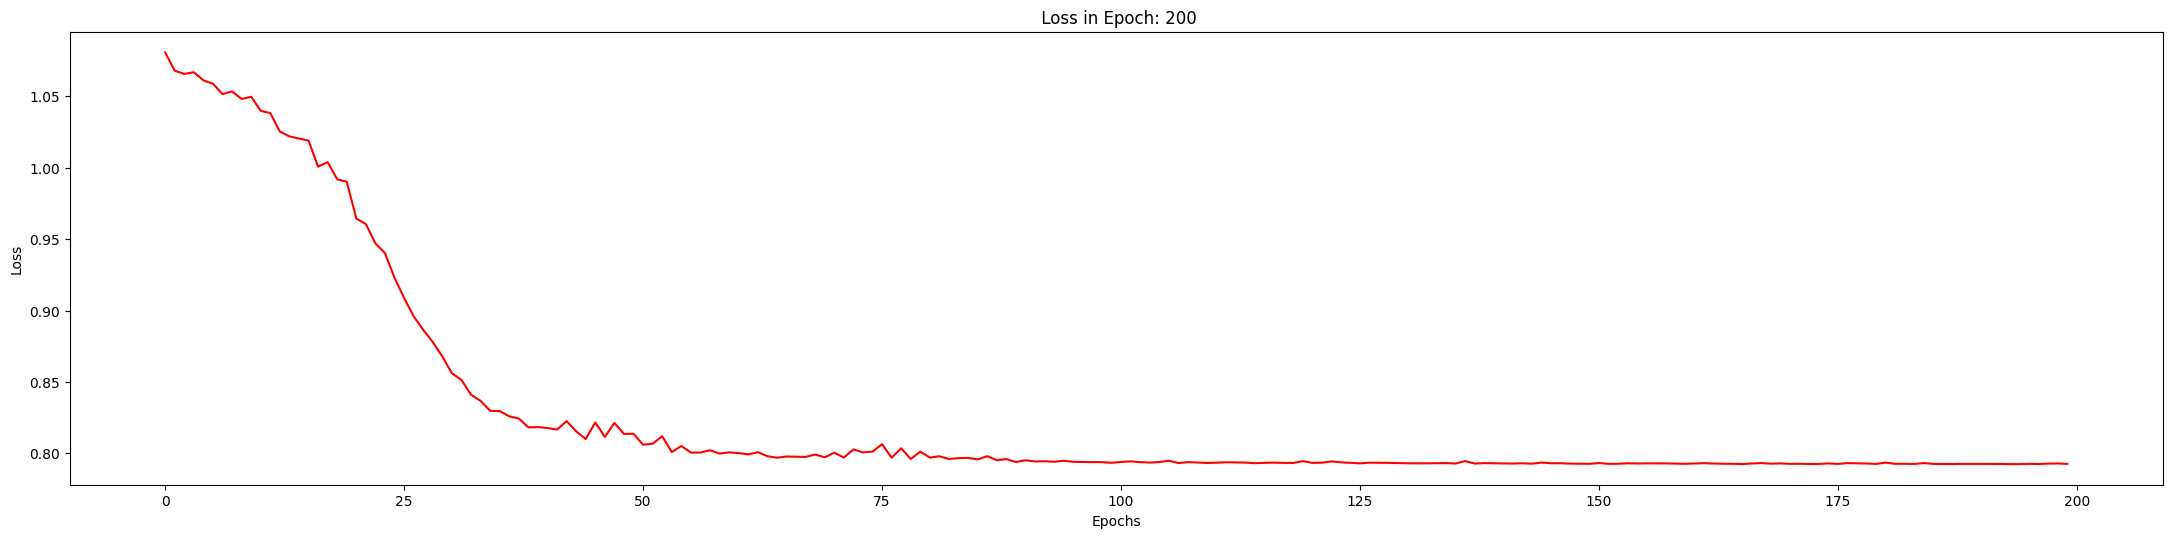

Epoch: 201, Model Loss: 0.7924
Epoch: 202, Model Loss: 0.7926
Epoch: 203, Model Loss: 0.7930
Epoch: 204, Model Loss: 0.7927
Epoch: 205, Model Loss: 0.7924
Epoch: 206, Model Loss: 0.7924
Epoch: 207, Model Loss: 0.7925
Epoch: 208, Model Loss: 0.7930
Epoch: 209, Model Loss: 0.7933
Epoch: 210, Model Loss: 0.7923
Epoch: 211, Model Loss: 0.7932
Epoch: 212, Model Loss: 0.7924
Epoch: 213, Model Loss: 0.7925
Epoch: 214, Model Loss: 0.7925
Epoch: 215, Model Loss: 0.7923
Epoch: 216, Model Loss: 0.7929
Epoch: 217, Model Loss: 0.7927
Epoch: 218, Model Loss: 0.7928
Epoch: 219, Model Loss: 0.7924
Epoch: 220, Model Loss: 0.7923
Epoch: 221, Model Loss: 0.7924
Epoch: 222, Model Loss: 0.7924
Epoch: 223, Model Loss: 0.7923
Epoch: 224, Model Loss: 0.7924
Epoch: 225, Model Loss: 0.7923
Epoch: 226, Model Loss: 0.7923
Epoch: 227, Model Loss: 0.7927
Epoch: 228, Model Loss: 0.7923
Epoch: 229, Model Loss: 0.7927
Epoch: 230, Model Loss: 0.7923
Epoch: 231, Model Loss: 0.7923
Epoch: 232, Model Loss: 0.7923
Epoch: 2

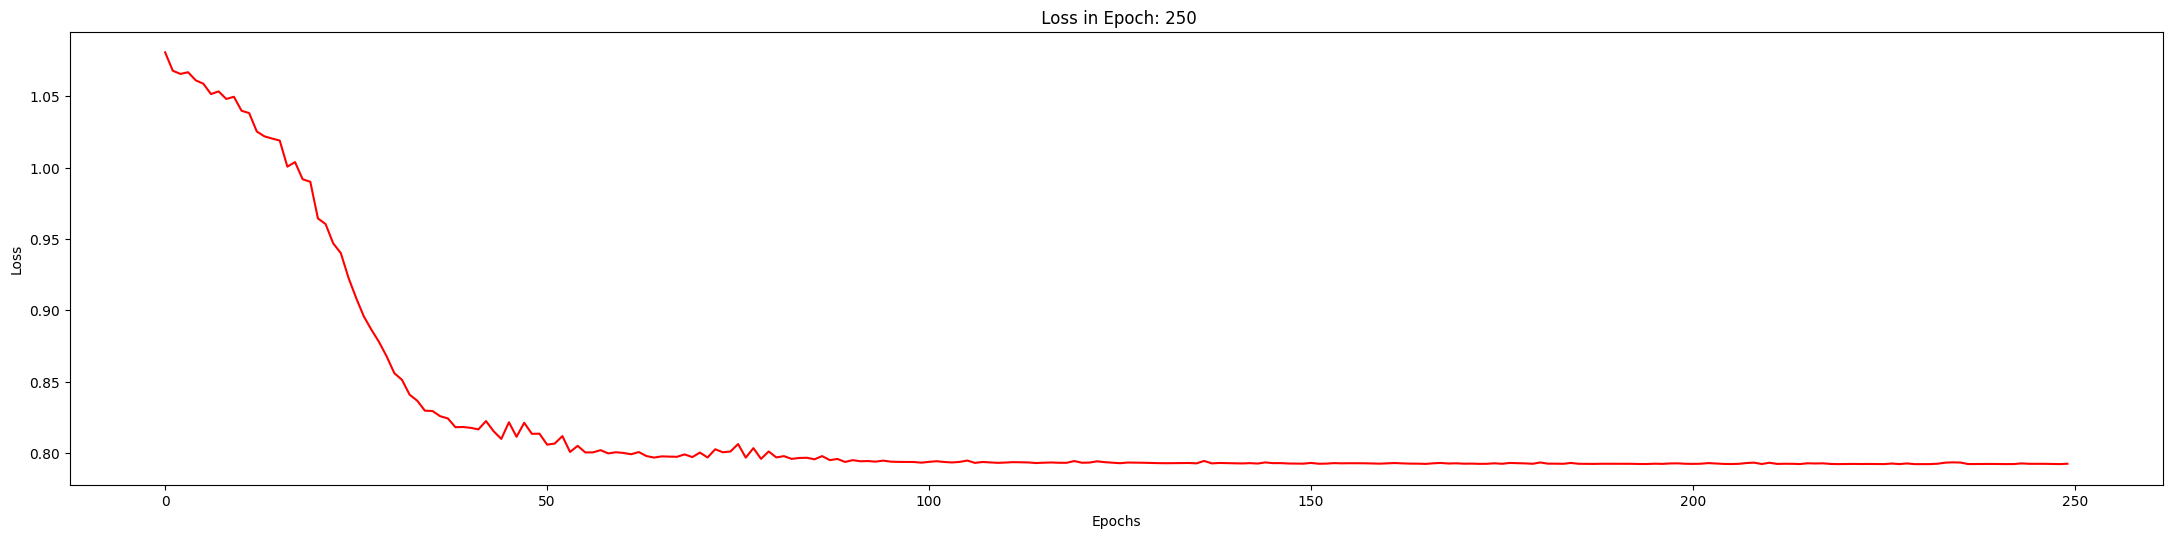

Epoch: 251, Model Loss: 0.7923
Epoch: 252, Model Loss: 0.7924
Epoch: 253, Model Loss: 0.7924
Epoch: 254, Model Loss: 0.7923
Epoch: 255, Model Loss: 0.7923
Epoch: 256, Model Loss: 0.7923
Epoch: 257, Model Loss: 0.7925
Epoch: 258, Model Loss: 0.7941
Epoch: 259, Model Loss: 0.7927
Epoch: 260, Model Loss: 0.7924
Epoch: 261, Model Loss: 0.7923
Epoch: 262, Model Loss: 0.7923
Epoch: 263, Model Loss: 0.7930
Epoch: 264, Model Loss: 0.7925
Epoch: 265, Model Loss: 0.7925
Epoch: 266, Model Loss: 0.7925
Epoch: 267, Model Loss: 0.7924
Epoch: 268, Model Loss: 0.7923
Epoch: 269, Model Loss: 0.7923
Epoch: 270, Model Loss: 0.7931
Epoch: 271, Model Loss: 0.7927
Epoch: 272, Model Loss: 0.7927
Epoch: 273, Model Loss: 0.7924
Epoch: 274, Model Loss: 0.7923
Epoch: 275, Model Loss: 0.7922
Epoch: 276, Model Loss: 0.7923
Epoch: 277, Model Loss: 0.7924
Epoch: 278, Model Loss: 0.7923
Epoch: 279, Model Loss: 0.7923
Epoch: 280, Model Loss: 0.7923
Epoch: 281, Model Loss: 0.7923
Epoch: 282, Model Loss: 0.7923
Epoch: 2

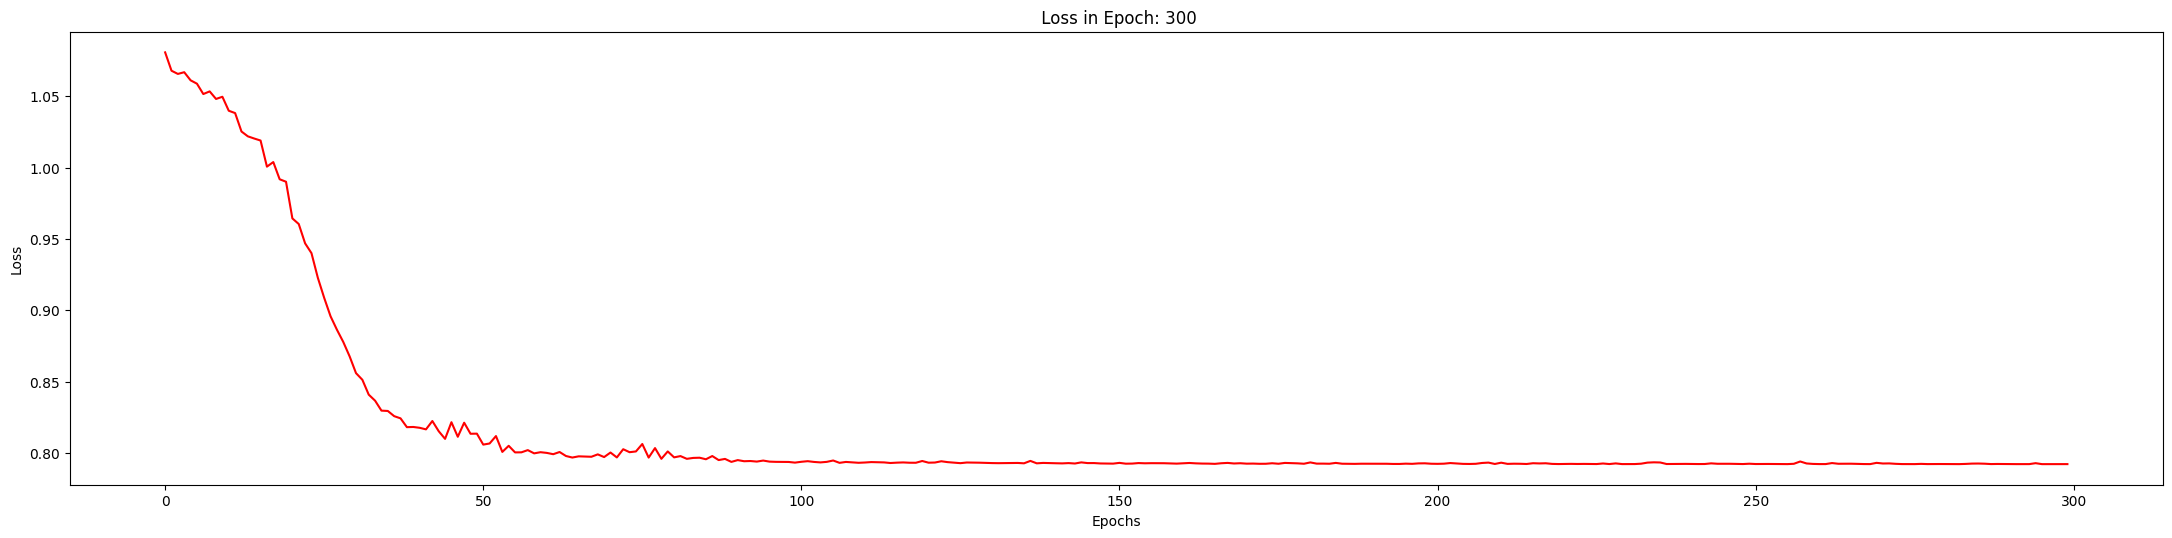

In [14]:
EPOCHS = 300
load_index = 0

train(EPOCHS, load_index)

## **DGCNN**

In [39]:
import DGCNN as dgcnn_model
GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh',
                                    mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=17, node_feat_size=7,
                                    hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])

tanh is Selected.
tanh is Selected.


In [32]:
print(GNN_Model)

DGCNN_Model(
  (gnn_layers): dgcnn_gnn_layers(
    (gnn_layers): Sequential(
      (0): GNN_DGCNN(
        (conv_params): Linear(in_features=13, out_features=32, bias=False)
      )
      (1): GNN_DGCNN(
        (conv_params): Linear(in_features=32, out_features=32, bias=False)
      )
      (2): GNN_DGCNN(
        (conv_params): Linear(in_features=32, out_features=32, bias=False)
      )
      (3): GNN_DGCNN(
        (conv_params): Linear(in_features=32, out_features=7, bias=False)
      )
    )
  )
  (sort_pool): SortPooling()
  (classic_conv): MLP_DGCNN(
    (conv1d_1): Conv1d(1, 16, kernel_size=(2,), stride=(2,), bias=False)
    (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1d_2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), bias=False)
    (linear1): Linear(in_features=800, out_features=128, bias=False)
    (linear2): Linear(in_features=128, out_features=2, bias=False)
    (dropout_linear1): Dropout(p=0.5, inplace=False)
  )
)


In [40]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [41]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [35]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [81]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_dataloader:

        final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, output_h1, dropout_output_h1, output_h2, softmaxed_h2 = GNN_Model(batch_of_graphs, None)
        #print("softmaxed_h2: ", softmaxed_h2.size())

        batch_loss = loss_calculations(softmaxed_h2, batch_of_graphs.y)
        Pred_Labels.extend(softmaxed_h2.argmax(dim=1).detach().tolist())

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [45]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f} Accuracy: {training_acc}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
          #torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



Epoch: 001, Model Loss: 0.4969 Accuracy: 0.7819148936170213
Epoch: 002, Model Loss: 0.4713 Accuracy: 0.824468085106383
Epoch: 003, Model Loss: 0.4721 Accuracy: 0.8138297872340425
Epoch: 004, Model Loss: 0.4867 Accuracy: 0.7819148936170213
Epoch: 005, Model Loss: 0.4939 Accuracy: 0.776595744680851
Epoch: 006, Model Loss: 0.4839 Accuracy: 0.8138297872340425
Epoch: 007, Model Loss: 0.4933 Accuracy: 0.776595744680851
Epoch: 008, Model Loss: 0.4985 Accuracy: 0.7872340425531915
Epoch: 009, Model Loss: 0.4773 Accuracy: 0.8191489361702128
Epoch: 010, Model Loss: 0.5070 Accuracy: 0.7659574468085106
Epoch: 011, Model Loss: 0.5056 Accuracy: 0.7712765957446809
Epoch: 012, Model Loss: 0.4640 Accuracy: 0.8297872340425532
Epoch: 013, Model Loss: 0.4988 Accuracy: 0.7819148936170213
Epoch: 014, Model Loss: 0.4996 Accuracy: 0.7872340425531915
Epoch: 015, Model Loss: 0.4931 Accuracy: 0.7872340425531915
Epoch: 016, Model Loss: 0.4780 Accuracy: 0.8191489361702128
Epoch: 017, Model Loss: 0.4890 Accuracy: 0.

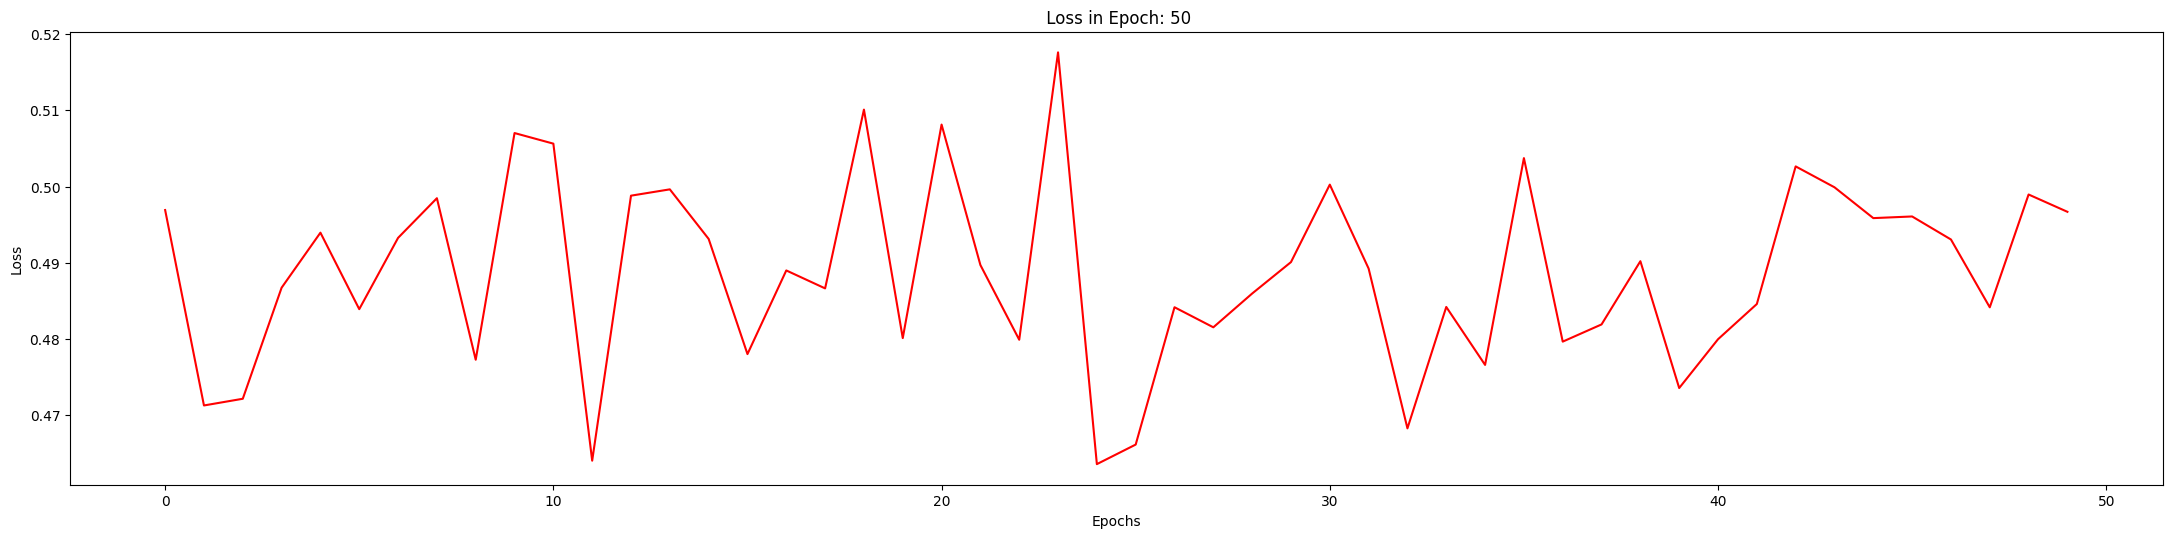

Epoch: 051, Model Loss: 0.4875 Accuracy: 0.7978723404255319
Epoch: 052, Model Loss: 0.4860 Accuracy: 0.7925531914893617
Epoch: 053, Model Loss: 0.4798 Accuracy: 0.7978723404255319
Epoch: 054, Model Loss: 0.4876 Accuracy: 0.8085106382978723
Epoch: 055, Model Loss: 0.4925 Accuracy: 0.776595744680851
Epoch: 056, Model Loss: 0.5014 Accuracy: 0.7872340425531915
Epoch: 057, Model Loss: 0.4658 Accuracy: 0.824468085106383
Epoch: 058, Model Loss: 0.4954 Accuracy: 0.7712765957446809
Epoch: 059, Model Loss: 0.4962 Accuracy: 0.776595744680851
Epoch: 060, Model Loss: 0.5000 Accuracy: 0.7659574468085106
Epoch: 061, Model Loss: 0.4947 Accuracy: 0.7925531914893617
Epoch: 062, Model Loss: 0.5020 Accuracy: 0.7659574468085106
Epoch: 063, Model Loss: 0.4733 Accuracy: 0.8138297872340425
Epoch: 064, Model Loss: 0.4820 Accuracy: 0.8138297872340425
Epoch: 065, Model Loss: 0.4917 Accuracy: 0.7925531914893617
Epoch: 066, Model Loss: 0.5006 Accuracy: 0.7659574468085106
Epoch: 067, Model Loss: 0.5055 Accuracy: 0.

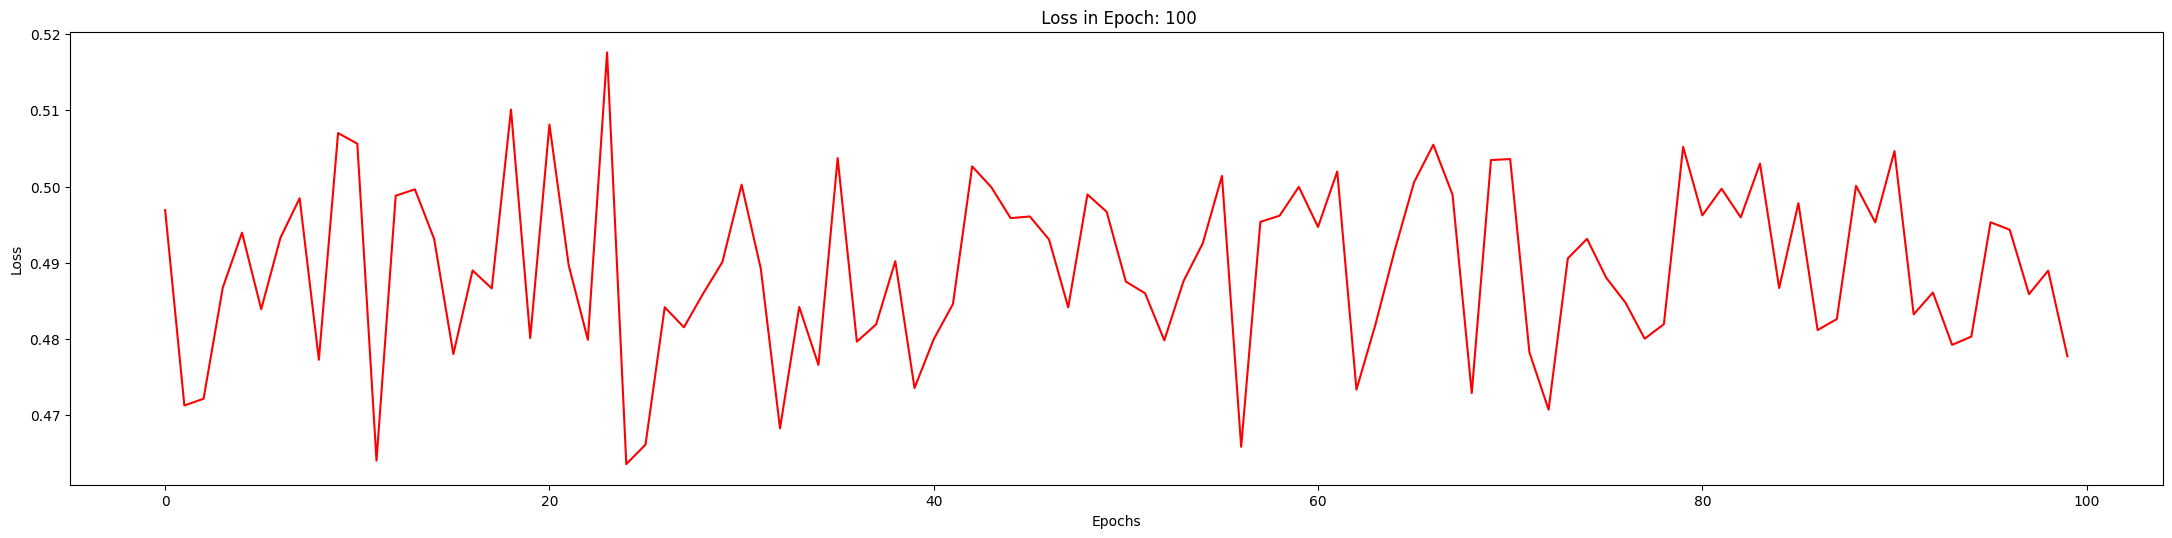

In [46]:
EPOCHS = 100
load_index = 0

train(EPOCHS, load_index)

## **DIFFPOOL**

In [158]:
import DIFFPOOL as diffpool_model
GNN_Model = diffpool_model.DIFFPOOL_Model(embedding_input_dim=13, embedding_num_block_layers=1, embedding_hid_dim=64,
                                          new_feature_size=64, assignment_input_dim=13, assignment_num_block_layers=1,
                                          assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50],
                                          concat_neighborhood=False, num_classes=3, Weight_Initializer=1, Bias=classifier_bias,
                                          dropout_rate=0, normalize_graphsage=False, aggregation="mean", act_fun="ReLu",
                                          concat_diffpools_outputs=True, num_pooling=1, pooling="mean")

ReLu is Selected.


In [159]:
print(GNN_Model)

DIFFPOOL_Model(
  (diffpool_layers): Sequential(
    (0): Batched_DiffPool_Layer(
      (diffpool_embedding): Batched_DiffPool_Embedding_Layer(
        (DiffPool_Embedding): ModuleList(
          (0): GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=13, out_features=64, bias=True)
          )
          (1-2): 2 x GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
      (diffpool_assignment): Batched_DiffPool_Assignment_Layer(
        (diffPool_assignment): ModuleList(
          (0): GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=13, out_features=64, bias=True)
          )
          (1-2): 2 x GNN_Batched_GraphSage_Layer(
            (learnable_weights): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )
    )
  )
  (last_extra_embedding): Batched_DiffPool_Embedding_Layer(
    (DiffPool_Embedding): Mod

In [160]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [161]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [162]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [165]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in fake_dataloader:

        concatination_list_of_poolings, prediction_output = GNN_Model(batch_of_graphs, None)
        Pred_Labels.extend(prediction_output.argmax(dim=1).detach().tolist())
        batch_loss = loss_calculations(prediction_output, batch_of_graphs.y)

        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [166]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f} Accuracy: {training_acc}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
          #torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



In [167]:
EPOCHS = 10
load_index = 0

train(EPOCHS, load_index)

Epoch: 001, Model Loss: 1.1003 Accuracy: 0.38
Epoch: 002, Model Loss: 1.0731 Accuracy: 0.37
Epoch: 003, Model Loss: 1.0659 Accuracy: 0.43
Epoch: 004, Model Loss: 1.0515 Accuracy: 0.59
Epoch: 005, Model Loss: 1.0030 Accuracy: 0.53
Epoch: 006, Model Loss: 1.0030 Accuracy: 0.45
Epoch: 007, Model Loss: 0.9901 Accuracy: 0.51
Epoch: 008, Model Loss: 0.9928 Accuracy: 0.5
Epoch: 009, Model Loss: 0.9647 Accuracy: 0.52
Epoch: 010, Model Loss: 0.9831 Accuracy: 0.52


## **GIN**

In [169]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)


import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=13, mlp_hid_dim=20,
                                mlp_output_dim=13, mlp_act_fun="ReLu", num_classes=3, dropout_rate=classifier_dropout,
                                Weight_Initializer=1)
print(GNN_Model)

GIN_Model(
  (gin_mlp_layers): ModuleList(
    (0-3): 4 x GIN_MLPs(
      (gin_mlp_layers): ModuleList(
        (0): Linear(in_features=13, out_features=20, bias=True)
        (1): Linear(in_features=20, out_features=13, bias=True)
      )
      (gin_batch_normalization): ModuleList(
        (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (global_summing): GlobalSUMPool()
  (lin1): Linear(in_features=65, out_features=65, bias=True)
  (lin2): Linear(in_features=65, out_features=3, bias=True)
  (dorpout): Dropout(p=0.1, inplace=False)
)


In [ ]:
print(GNN_Model)

In [139]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [140]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [141]:
def visualize_losses(GNN_Model_losses, epoch_history):
    GNN_Model_losses_list = torch.stack(GNN_Model_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(" Loss in Epoch: " + str(epoch_history))

    ax.plot(GNN_Model_losses_list, color='r')

    #plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

In [119]:
def train_step():
    GNN_Model_loss_batch = []
    Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in fake_dataloader:

        mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs, None)
        batch_loss = loss_calculations(lin2_output_softmaxed, batch_of_graphs.y)

        Pred_Labels.extend(lin2_output_softmaxed.argmax(dim=1).detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, Pred_Labels)

In [110]:
GNN_Model_training_Acc_per_epoch = []
GNN_Model_training_time_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        t1 = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        GNN_Model_training_time_per_epoch.append(perf_counter()-t1)
        print(f'Epoch: {epoch+1:03d}, Model Loss: {GNN_Model_training_loss:.4f} Accuracy: {training_acc}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        GNN_Model_training_Acc_per_epoch.append(training_acc)
        #break

        if (epoch + load_index + 1) % 50 == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        #if (epoch + load_index + 1) % 100 == 0 and epoch > 0:
          #torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")



In [142]:
EPOCHS = 10
load_index = 0

train(EPOCHS, load_index)

Epoch: 001, Model Loss: 1.2236 Accuracy: 0.31
Epoch: 002, Model Loss: 1.2047 Accuracy: 0.34
Epoch: 003, Model Loss: 1.1581 Accuracy: 0.38
Epoch: 004, Model Loss: 1.1716 Accuracy: 0.38
Epoch: 005, Model Loss: 1.2160 Accuracy: 0.33
Epoch: 006, Model Loss: 1.2035 Accuracy: 0.34
Epoch: 007, Model Loss: 1.2525 Accuracy: 0.3
Epoch: 008, Model Loss: 1.1997 Accuracy: 0.35
Epoch: 009, Model Loss: 1.1969 Accuracy: 0.35
Epoch: 010, Model Loss: 1.1708 Accuracy: 0.37
